In [ ]:
import torch

torch.__version__

'2.2.1+cu121'

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Sat Mar 30 23:57:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data-preprocessing

In [ ]:
from pathlib import Path
from zipfile import ZipFile

data_path = Path("Data")
image_path = data_path / "Date_Fruit_Image_Dataset"

# Extract train and test images and save it in image_path
with ZipFile(data_path / "Date_Fruit_Image_Dataset_Splitted_Test.zip") as zip_ref:
  zip_ref.extractall(image_path)
with ZipFile(data_path / "Date_Fruit_Image_Dataset_Splitted_Train.zip") as zip_ref:
  zip_ref.extractall(image_path)

In [ ]:
# Setup train and test directories
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Set the transform of the images
from torchvision import transforms
simple_data_transform = transforms.Compose([
    transforms.Resize(size = (224 , 224)),# Resize to save space and follow best practice
    # Flip random samples horziantly
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn image to tensor
    transforms.ToTensor()
])

In [ ]:
from torchvision.datasets import ImageFolder
train_data = ImageFolder(root = train_dir , transform = simple_data_transform)
test_data = ImageFolder(root = test_dir , transform = simple_data_transform)

In [ ]:
class_names = train_data.classes
class_names

['Ajwa',
 'Galaxy',
 'Mejdool',
 'Meneifi',
 'NabtatAli',
 'Rutab',
 'Shaishe',
 'Sokari',
 'Sugaey']

In [ ]:
len(train_data) , len(test_data)

(1156, 502)

### Visualize sample images

In [ ]:
import matplotlib.pyplot as plt
def visualize(img , label):
  # To visualize in matplotlib we need to rearrange the order of dimensions
  img_permute = img.permute(1,2,0)

  # Plot the image
  plt.figure(figsize=(10,7))
  plt.imshow(img_permute)
  plt.axis(False)
  plt.title(class_names[label])

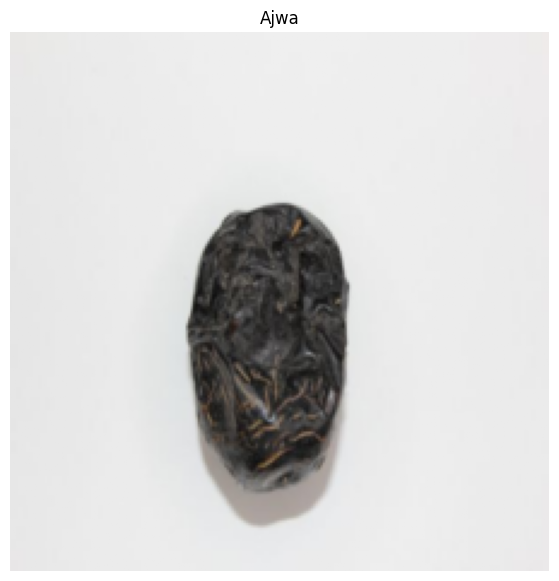

In [ ]:
img , label = train_data[0][0] , train_data[0][1]
visualize(img , label)

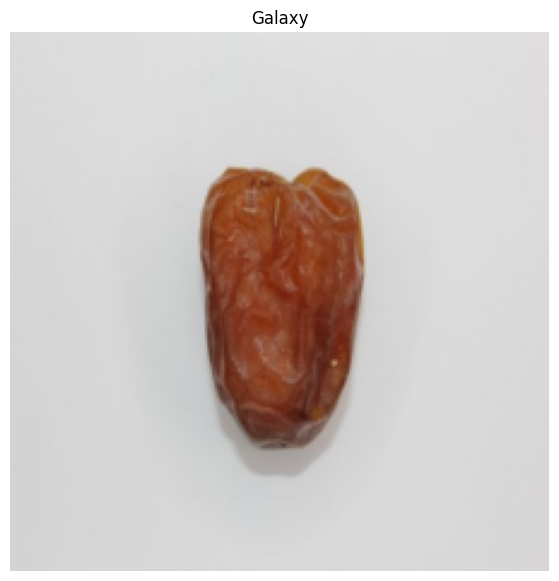

In [ ]:
img , label = test_data[100][0] , test_data[100][1]
visualize(img , label)

In [ ]:
# Put your data to dataloader in order to be iterable and separated as batches
from torch.utils.data import DataLoader
import os
NUM_OF_WORKERS = os.cpu_count() # Number of available cpu's
BATCH_SIZE = 64 # This and workers number vary depending on your hardware but the big it was the faster the training will be

train_dataloader = DataLoader(train_data , batch_size = BATCH_SIZE , num_workers = NUM_OF_WORKERS , shuffle = True)
test_dataloader = DataLoader(test_data , batch_size = BATCH_SIZE , num_workers = NUM_OF_WORKERS)

train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c4061982ad0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c4061982860>)

## Model construction

In [ ]:
from torch import nn
class DateCNNModel(nn.Module):
  def __init__(self , input_shape: int , hidden_units: int , output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, padding=1, stride=1),
      nn.BatchNorm2d(hidden_units*2),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, padding=1, stride=1),
      nn.BatchNorm2d(hidden_units*2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_3 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),
      nn.BatchNorm2d(hidden_units*4),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),
      nn.BatchNorm2d(hidden_units*4),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )


    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(in_features= 40 * 28 * 28, out_features=output_shape),
    )



  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.classifier(x)
    return x

In [ ]:
model = DateCNNModel(input_shape = 3,# RGB Channels (Red , Blue , Green) or 1 if it's Black and White
                     hidden_units = 10,# Hidden units in the layers (Hyper parameter can't be adjusted depending on the situation)
                     output_shape = len(class_names)# Output of the model should be a class
                     ).to(device) # Put the model in the appropriate device
model

DateCNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
 

In [ ]:
# Print model summary
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
summary(model , input=(3 , 224 , 224))

Layer (type:depth-idx)                   Param #
DateCNNModel                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─BatchNorm2d: 2-2                  20
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       910
│    └─BatchNorm2d: 2-5                  20
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-8                       1,820
│    └─BatchNorm2d: 2-9                  40
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      3,620
│    └─BatchNorm2d: 2-12                 40
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-15                      7,240
│    └─BatchNorm2d: 2-16                 80
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2

In [ ]:
import requests
from pathlib import Path

if not Path("helper_function.py").is_file():
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py' , 'wb') as f:
    f.write(request.content)

from helper_functions import accuracy_fn # This will help us for accuracy

In [ ]:
def train_step(model:nn.Module , train_data:torch.utils.data.DataLoader , loss_fn: nn.Module , optimizer: torch.optim.Optimizer, accuracy_fn  , device: int = device):
  """This function will do one training step"""
  # Put the model in the training mode
  model.train()

  train_loss , train_acc = 0,0
  # Iterate over each batch in train_data
  for batch , (X,y) in enumerate(train_data):
    # Put the batches in appropriate device
    X,y = X.to(device) , y.to(device)

    # Make prediction
    y_logits = model(X)

    # Calculate loss
    loss = loss_fn(y_logits , y)
    train_loss += loss
    # Calculate accuracy
    y_pred_labels = torch.argmax(torch.softmax(y_logits , dim = 1) , dim = 1) # transform the logit data into max number from the softmax
    accuracy = accuracy_fn(y , y_pred_labels)
    train_acc += accuracy

    # Zero the gradients
    optimizer.zero_grad()

    # Backprobagation
    loss.backward()

    # Update gradients
    optimizer.step()

  # Average the train loss and accuracy
  train_loss /= len(train_data)
  train_acc /= len(train_data)

  return train_loss , train_acc

In [ ]:
def test_step(model:nn.Module , test_data:torch.utils.data.DataLoader , loss_fn: nn.Module , accuracy_fn  , device: int = device):
  """This function will do one training step"""
  # Put the model in the evaluating mode
  model.eval()
  with torch.inference_mode():
    test_loss , test_acc = 0,0
    # Iterate over each batch in train_data
    for batch , (X,y) in enumerate(test_data):
      # Put the batches in appropriate device
      X,y = X.to(device) , y.to(device)

      # Make prediction
      y_logits = model(X)

      # Calculate loss
      loss = loss_fn(y_logits , y)
      train_loss += loss
      # Calculate accuracy
      y_pred_labels = torch.argmax(torch.softmax(y_logits , dim = 1) , dim = 1) # transform the logit data into max number from the softmax
      accuracy = accuracy_fn(y , y_pred_labels)
      train_acc += accuracy

    # Average the train loss and accuracy
    train_loss /= len(train_data)
    train_acc /= len(train_data)

    return test_loss , test_acc

In [ ]:
# Create a function to time our experiments
from timeit import default_timer as timer
from tqdm.auto import tqdm
def train(model:nn.Module , train_data:torch.utils.data.DataLoader , eval_data : torch.utils.data.DataLoader, loss_fn: nn.Module , optimizer: torch.optim.Optimizer, accuracy_fn , epochs:int , device: int = device):
  """This function will train the model and evaluate it and return a dictionary of the results"""

  # Initialize lists to store metrics
  metrics = {
      "Model name": model.__class__.__name__,
      "Train loss": [],
      "Train accuracy": [],
      "Test loss": [],
      "Test accuracy": [],
      "Training Time": []
  }

  start_time = timer()

  for epoch in tqdm(range(epochs)):
    # Train
    train_loss , train_acc = train_step(model = model , train_data = train_data , loss_fn = loss_fn , optimizer = optimizer , accuracy_fn = accuracy_fn , device = device)
    print(f"Epoch: {epoch}\nTrain loss: {train_loss:.4f}  Train accuracy {train_acc:.2f}")


    # Evaluate
    test_loss , test_acc = train_step(model = model , train_data = train_data , loss_fn = loss_fn , optimizer = optimizer , accuracy_fn = accuracy_fn , device = device)
    # Append metrics for this epoch
    metrics["Train loss"].append(train_loss.item())
    metrics["Train accuracy"].append(train_acc)
    metrics["Test loss"].append(test_loss.item())
    metrics["Test accuracy"].append(test_acc)

  end_time = timer()

  return metrics , {"Model name": model.__class__.__name__ ,
          "Train loss": train_loss.item() ,
          "Train accuracy": train_acc,
          "Test loss": test_loss.item(),
          "Test accuracy": test_acc,
          "Training Time": end_time - start_time}


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =model.parameters() , lr = 0.001)

metrics, results = train(model = model , train_data = train_dataloader , eval_data = test_dataloader , loss_fn = loss_fn , optimizer = optimizer , accuracy_fn = accuracy_fn , epochs = 30 , device = device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
Train loss: 5.9768  Train accuracy 28.29
Epoch: 1
Train loss: 1.1158  Train accuracy 63.65
Epoch: 2
Train loss: 0.5416  Train accuracy 83.96
Epoch: 3
Train loss: 0.6980  Train accuracy 81.66
Epoch: 4
Train loss: 0.3731  Train accuracy 87.91
Epoch: 5
Train loss: 0.2259  Train accuracy 93.01
Epoch: 6
Train loss: 0.2414  Train accuracy 92.27
Epoch: 7
Train loss: 0.1747  Train accuracy 93.67
Epoch: 8
Train loss: 0.1131  Train accuracy 96.30
Epoch: 9
Train loss: 0.2032  Train accuracy 93.34
Epoch: 10
Train loss: 0.1242  Train accuracy 95.48
Epoch: 11
Train loss: 0.1491  Train accuracy 96.22
Epoch: 12
Train loss: 0.2356  Train accuracy 92.60
Epoch: 13
Train loss: 0.1114  Train accuracy 96.71
Epoch: 14
Train loss: 0.2276  Train accuracy 92.93
Epoch: 15
Train loss: 0.1933  Train accuracy 93.50
Epoch: 16
Train loss: 0.0975  Train accuracy 96.63
Epoch: 17
Train loss: 0.7688  Train accuracy 86.18
Epoch: 18
Train loss: 0.1463  Train accuracy 94.65
Epoch: 19
Train loss: 0.3749  Train accur

In [ ]:
results

{'Model name': 'DateCNNModel',
 'Train loss': 0.15870784223079681,
 'Train accuracy': 95.64144736842105,
 'Test loss': 0.12466982752084732,
 'Test accuracy': 96.54605263157895,
 'Training Time': 278.3067422109998}

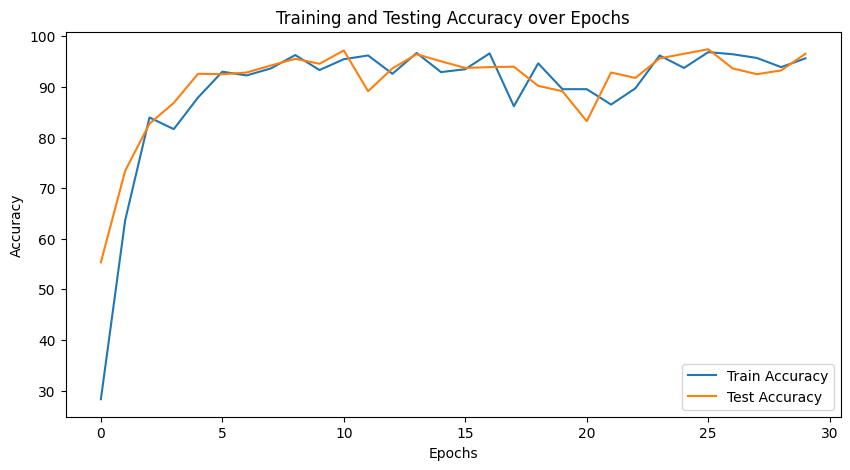

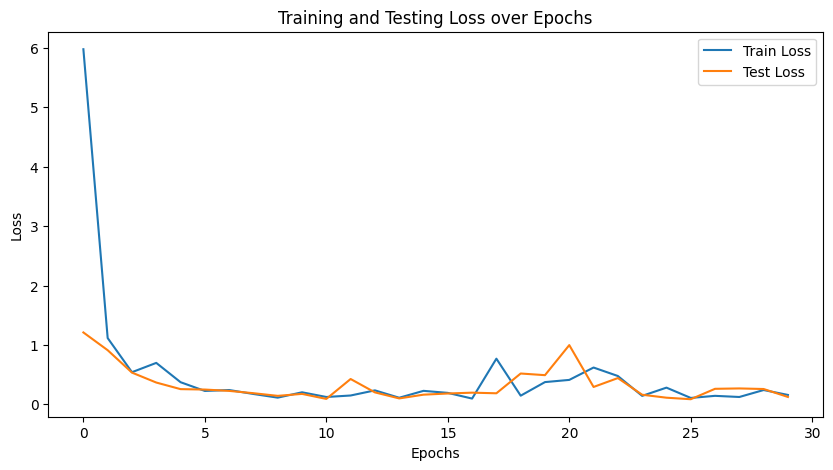

In [ ]:
# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics["Train accuracy"], label='Train Accuracy')
plt.plot(metrics["Test accuracy"], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

# Plot for loss
plt.figure(figsize=(10, 5))
plt.plot(metrics["Train loss"], label='Train Loss')
plt.plot(metrics["Test loss"], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

## Saving the model

In [ ]:
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents = True , exist_ok = True)

MODEL_NAME = "cnn_date_fruit_classifier.pth"
SAVE_MODEL_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj = model.state_dict() , f = SAVE_MODEL_PATH)